# 0.0 Imports

In [1]:
!pip install inflection

In [2]:
import pandas as pd
import inflection
import datetime
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive
from IPython.display import Image

## 0.1 Helper Functions

In [3]:
plt.rcParams['figure.figsize'] = [30, 10]
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('/content/drive/MyDrive/data/ds_producao/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/MyDrive/data/ds_producao/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case,cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()/df1.shape[0]*100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NAs

- Formas de lidar com NAs:
  1. Excluir os NAs.
  2. Usando algoritmos que façam a substituição baseada no comportamento da coluna (ex.: media ou mediana da coluna).
  3. Pensar no negócio, como ele se comporta e porquê ele gerou esse NA.

In [11]:
# competition_distance:   
#   A: não há competidor para essa loja, ou o competidor mais próximo está tão distante que não representa uma competição     
#   R: usar uma distância muito acima da máxima da coluna (criar um outlier) é o mesmo que dizer que não há competidor para essa loja
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month 
#   A: a loja não tem um competidor próximo, ou não se sabe quando ele abriu
#   R: extrair o mês da data da venda
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
#   A: a loja não tem um competidor próximo, ou não se sabe quando ele abriu
#   R: extrair o ano da data da venda
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week 
#   A: a loja não manteve a promoção estendida
#   R: extrair a semana da data da venda  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )         

# promo2_since_year   
#   A: a loja não tem um competidor próximo, ou não se sabe quando ele abriu
#   R: extrair o ano da data da venda 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )                 

# promo_interval  
#   A: a loja não participou de promoções prolongadas
#   R: preencher com 0 e criar uma nova coluna is_promo
month_map = { 1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' } 
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map ) # extrai o mês int e mapeia com o dicionario, tranformando em string
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

- Objetivos:
  - Ganhar conhecimento de negócio
  - Detectar alguns erros

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
# Central Tendency - average/mean, median
_mean   = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
_min      = pd.DataFrame(num_attributes.apply(min)).T
_max      = pd.DataFrame(num_attributes.apply(max)).T
_std      = pd.DataFrame(num_attributes.apply(np.std)).T
_range    = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
_skew     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
#skew+ = concentração perto do 0
#skew- = concentração longe do 0
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
#kurtosis alta = concentração alta
#kurtosis baixa = concentração baixa

# Concatenate
_min,_max,_std,_range,_skew,_kurtosis
ds_num = pd.concat( [ _min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
ds_num.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

In [18]:
ds_num

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

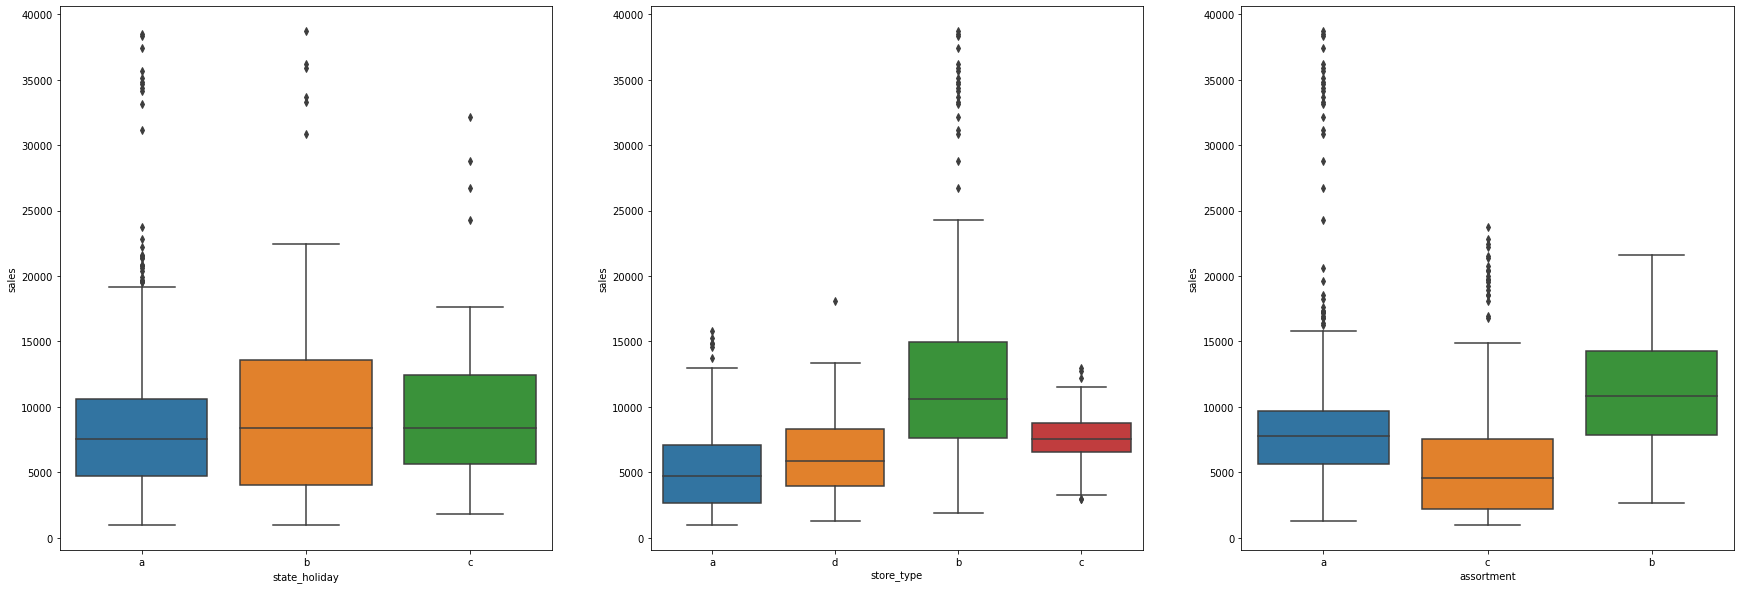

In [20]:
aux1 = df1[(df1['state_holiday'] != '0')&(df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Hypothesis Gathering

## 2.1. Hypothesis mindmap

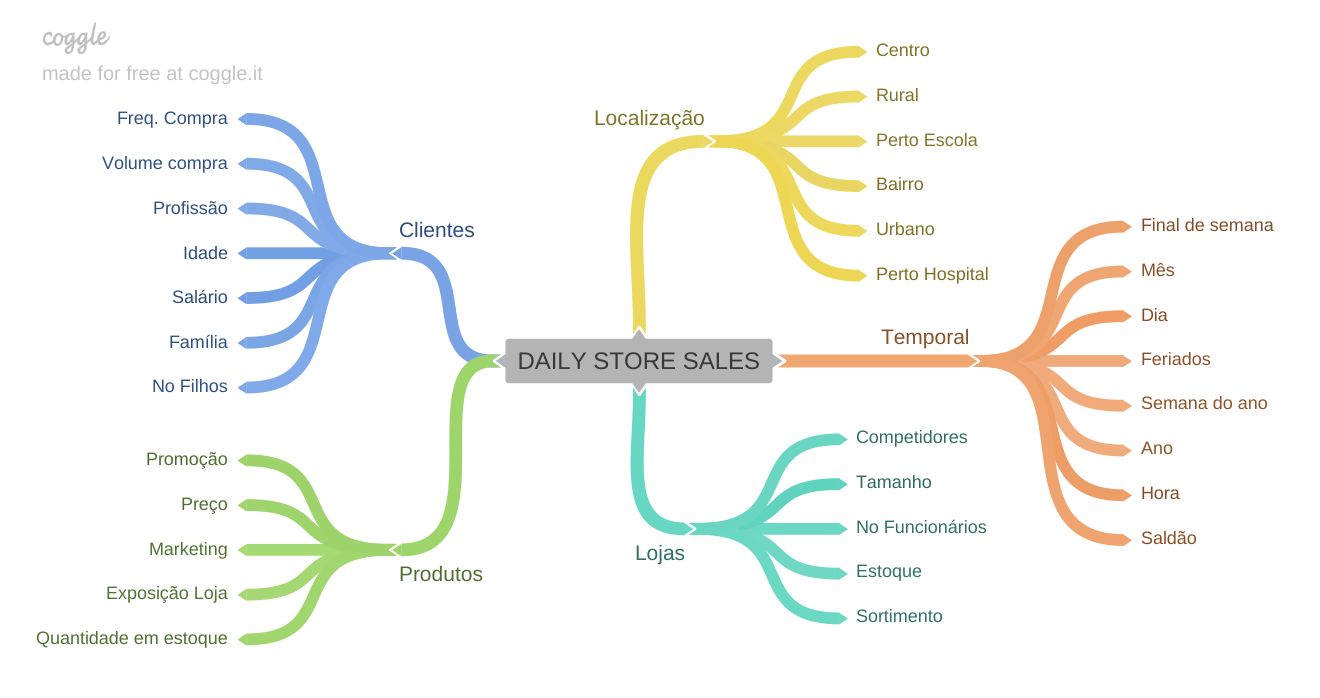

In [21]:
Image('/content/drive/MyDrive/data/ds_producao/mindmap_hipothesys.png')

## 2.2. Hypothesis creation

### 2.2.1. Store Hypothesis

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Product Hypothesis

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3. Time Hypothesis

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Hypothesis Final List

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

# 3.0 Feature Engineering

In [22]:
df2 = df1.copy()

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'],
                                                                  month = x['competition_open_since_month'], 
                                                                  day=1), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'none')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,none,none,none,none,none
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [26]:
!git init

Initialized empty Git repository in /content/.git/


In [27]:
!git config --global user.name "Rodrigo Vieira"

In [28]:
!git config --global user.email rodrigov.945@gmail.com

In [30]:
!git add /content/drive/MyDrive/data/ds_producao/mindmap_hipothesys.png

In [33]:
!git add /content/drive/MyDrive/ColabNotebooks/ds_producao.ipynb

fatal: pathspec '/content/drive/MyDrive/ColabNotebooks/ds_producao.ipynb' did not match any files
